# INM 706
# Deep Learning for Sequence Analysis

# Sentiment Analysis using twitter dataset


## Nabeel Shaikh 
## Faisal Mungi





---

* Process Data through pytorch Dataset  
* Make batches through pytorch Dataloader  
  * Pad tweets to the max length in the batch
* Max Pooling and Average Pooling
  * RNN model (GRU) with concat pooling
* [Ignite](https://pytorch.org/ignite/) training callbacks


## Installing libraries

In [ ]:
!pip install spacy
!pip install pytorch-ignite

## Imports

In [ ]:
%matplotlib inline
import sys
import re
import pathlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm.auto import tqdm, trange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import ignite
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Spacy version:', spacy.__version__)
print('Ignite version:', ignite.__version__)

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Pandas version: 1.3.5
Pytorch version: 1.11.0+cu113
Spacy version: 2.2.4
Ignite version: 0.4.9


## 1. Process Data through pytorch Dataset

In [ ]:
#data_root = pathlib.Path('./data')

In [ ]:
df = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)
#data_root / 

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [ ]:
df.columns

Index(['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText'], dtype='object')

In [ ]:
df.isna()

,ItemID,Sentiment,SentimentSource,SentimentText
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1578607,False,False,False,False
1578608,False,False,False,False
1578609,False,False,False,False
1578610,False,False,False,False


In [ ]:
df.dropna(axis='columns')

""
0
1
2
3
4
...
1630843
1630844
1630845
1630846


In [ ]:
#df = df1
df.isna()

,ItemID,Sentiment,SentimentSource,SentimentText,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,False,False,False,False,True,True,True
1,False,False,False,False,True,True,True
2,False,False,False,False,True,True,True
3,False,False,False,False,True,True,True
4,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...
1630843,False,False,False,False,True,True,True
1630844,False,False,False,False,True,True,True
1630845,False,False,False,False,True,True,True
1630846,False,False,False,False,True,True,True


In [ ]:
df.columns

Index(['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText'], dtype='object')

In [ ]:
df.shape
df.head()

(1578612, 4)

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [ ]:
df.SentimentText.value_counts()

                     is so sad for my APL friend.............                                                                       1
Loved the short run in the rain with my new nike shorts!                                                                            1
lovely sunny morning + skirt and sandals + great coffe = good mood                                                                  1
Lovely sunny day!                                                                                                                   1
Lovely sunny day off to the albert dock with lots of kids look like old mother hubert lol  aud xxx                                  1
                                                                                                                                   ..
 why won't she answer                                                                                                               1
 why today of all days.                                       

In [ ]:
df['Sentiment'].unique()


array([0, 1])

In [ ]:
df.Sentiment.value_counts()

1    790177
0    788435
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

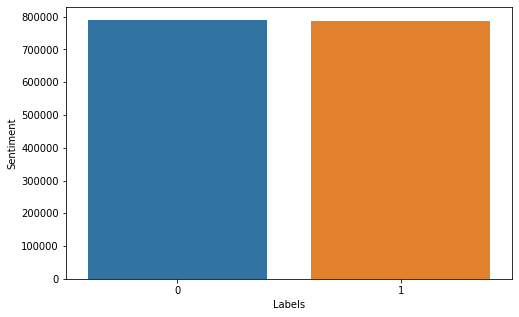

In [ ]:

fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(),y=df.Sentiment.value_counts());
#ax = sns.barplot(x=df.groupby('Sentiment'),y=df.Sentiment.value_counts())
ax.set(xlabel='Labels')

In [ ]:
# load csv in pandas dataframe
#df = pd.read_csv(data_root / 'Sentiment Analysis Dataset.csv', error_bad_lines=False)

#df = df.dropna()


# split the data into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)#, stratify=df[['SentimentText']])
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_df.shape, val_df.shape

((1262889, 4), (315723, 4))

### Custom class for data

In [ ]:
PAD = 0
UNK = 1

class SentimentDataset(Dataset):
    """Define the pytorch Dataset to process the tweets
       This class can be used for both training and validation dataset
       Run it for training data and pass the word2idx and idx2word when running
       for validation data
    """
    
    def __init__(self, df, word2idx=None, idx2word=None, max_vocab_size=50000):
        print('Processing Data')
        self.df = df
        print('Removing white space...')
        self.df.SentimentText = self.df.SentimentText.progress_apply(lambda x: x.strip())
        self.nlp = spacy.load('en_core_web_sm',disable=['parser', 'tagger', 'ner'])
        if word2idx is None:
            print('Building Counter...')
            word_counter = self.build_counter()
            print('Building Vocab...')
            self.word2idx, self.idx2word = self.build_vocab(word_counter, max_vocab_size)
        else:
            self.word2idx, self.idx2word = word2idx, idx2word
        print('*'*100)
        print('Dataset info:')
        print(f'Number of Tweets: {self.df.shape[0]}')
        print(f'Vocab Size: {len(self.word2idx)}')
        print('*'*100)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        sent = self.df.SentimentText[idx]
        tokens = [w.text.lower() for w in self.nlp(self.tweet_clean(sent))]
        vec = self.vectorize(tokens, self.word2idx)
        return vec, self.df.Sentiment[idx]
    
    def tweet_clean(self, text):
        """Very basic text cleaning. This function can be built upon for
           better preprocessing
        """
        text = re.sub(r'[\s]+', ' ', text) # replace multiple white spaces with single space
#         text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # remove @ mentions
        text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
        return text.strip()
    
    def build_counter(self):
        """Tokenize the tweets using spacy and build vocabulary
        """
        words_counter = Counter()
        for sent in tqdm(self.df.SentimentText.values):
            words_counter.update(w.text.lower() for w in self.nlp(self.tweet_clean(sent)))
        return words_counter
    
    def build_vocab(self, words_counter, max_vocab_size):
        """Add pad and unk tokens and build word2idx and idx2word dictionaries
        """
        word2idx = {'<PAD>': PAD, '<UNK>': UNK}
        word2idx.update({word:i+2 for i, (word, count) in tqdm(enumerate(words_counter.most_common(max_vocab_size)))})
        idx2word = {idx: word for word, idx in tqdm(word2idx.items())}
        return word2idx, idx2word
    
    def vectorize(self, tokens, word2idx):
        """Convert tweet to vector
        """
        vec = [word2idx.get(token, UNK) for token in tokens]
        return vec

In [ ]:
vocab_size = 100000

In [ ]:
val_loss = []
val_acc = []

train_loss = []
train_acc = []

### Training dataset

In [ ]:
train_ds = SentimentDataset(train_df, max_vocab_size=vocab_size)

Processing Data
Removing white space...


Progress:   0%|          | 0/1262889 [00:00<?, ?it/s]

Building Counter...


  0%|          | 0/1262889 [00:00<?, ?it/s]

Building Vocab...


0it [00:00, ?it/s]

  0%|          | 0/100002 [00:00<?, ?it/s]

****************************************************************************************************
Dataset info:
Number of Tweets: 1262889
Vocab Size: 100002
****************************************************************************************************


### Validation dataset

In [ ]:
val_ds = SentimentDataset(val_df, word2idx=train_ds.word2idx, idx2word=train_ds.idx2word)

Processing Data
Removing white space...


Progress:   0%|          | 0/315723 [00:00<?, ?it/s]

****************************************************************************************************
Dataset info:
Number of Tweets: 315723
Vocab Size: 100002
****************************************************************************************************


## 2. Make batches through pytorch Dataloader

In [ ]:
batch_size = 1024

### Function to pad and transpose data (to be used in Dataloader)

In [ ]:
def collate_fn(data):
    """This function will be used to pad the tweets to max length
       in the batch and transpose the batch from 
       batch_size x max_seq_len to max_seq_len x batch_size.
       It will return padded vectors, labels and lengths of each tweets (before padding)
       It will be used in the Dataloader
    """
    data.sort(key=lambda x: len(x[0]), reverse=True)
    lens = [len(sent) for sent, label in data]
    labels = []
    padded_sents = torch.zeros(len(data), max(lens)).long()
    for i, (sent, label) in enumerate(data):
        padded_sents[i,:lens[i]] = torch.LongTensor(sent)
        labels.append(label)
    
    padded_sents = padded_sents.transpose(0,1)
    return padded_sents, torch.tensor(labels).long(), lens

### Train dataloader

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### Validation dataloader

In [ ]:
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=collate_fn)

## 3. Max Pooling and Average Pooling

### Concat pooling GRU model

In [ ]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb_drop = nn.Dropout(0.3)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, dropout=0.3)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths):
        self.h = self.init_hidden(seq.size(1))
        embs = self.emb_drop(self.emb(seq))
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)

        outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))             
        return F.log_softmax(outp, dim=-1) # it will return log of softmax
    
    def init_hidden(self, batch_size):
        return torch.zeros((1, batch_size,self.n_hidden), requires_grad=True).to(device)

In [ ]:
# (vocab_size + 2) is because of pad and unk added to the vocab
model_vocab_size = vocab_size + 2
embedding_dim = 100
rnn_hidden = 256
n_out = 2

model = ConcatPoolingGRUAdaptive(model_vocab_size, embedding_dim, rnn_hidden, n_out).to(device) 
optimizer = optim.Adam(model.parameters(), 1e-3)
loss_fn = F.nll_loss

## 4. Ignite training callbacks

*Ignite is all about callbacks.  
Training and evaluation is defined separately.  
You can define your single custom training and evaluator loop and add them to Engine.  
Add loss and accuracy to the trainer and evaluator.
Finally define early stopping and modelcheckpoint*

### Define single training and validation loop

In [ ]:
def process_function(engine, batch):
    """Single training loop to be attached to trainer Engine
    """
    model.train()
    optimizer.zero_grad()
    x, y, lens = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x, lens)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item(), torch.max(y_pred, dim=1)[1], y


def eval_function(engine, batch):
    """Single evaluator loop to be attached to trainer and evaluator Engine
    """
    model.eval()
    with torch.no_grad():
        x, y, lens = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x, lens)
        return y_pred, y
    
trainer = Engine(process_function)
train_evaluator = Engine(eval_function)
validation_evaluator = Engine(eval_function)

### Add metrics (Loss and Accuracy) to the trainer and evaluator

In [ ]:
def max_output_transform(output):
    """It convers the predicted ouput probabilties to indexes for accuracy calculation
    """
    y_pred, y = output
    return torch.max(y_pred, dim=1)[1], y

# attach running loss (will be displayed in progess bar)
RunningAverage(output_transform=lambda x: x[0]).attach(trainer, 'loss')

# attach running accuracy (will be displayed in progess bar)
RunningAverage(Accuracy(output_transform=lambda x: [x[1], x[2]])).attach(trainer, 'acc')

# attach accuracy and loss to train_evaluator
Accuracy(output_transform=max_output_transform).attach(train_evaluator, 'accuracy')
Loss(loss_fn).attach(train_evaluator, 'bce')

# attach accuracy and loss to validation_evaluator
Accuracy(output_transform=max_output_transform).attach(validation_evaluator, 'accuracy')
Loss(loss_fn).attach(validation_evaluator, 'bce')

### Report progress through tqdm progress bar

In [ ]:
pbar = ProgressBar(persist=True, bar_format="")
pbar.attach(trainer, ['loss', 'acc'])

### Log results after each epoch

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """This function will run after each epoch and 
       report the training loss and accuracy (defined above)
    """
    train_evaluator.run(train_dl)
    metrics = train_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_bce = metrics['bce']
    train_loss.append(avg_bce)
    train_acc.append(avg_accuracy)
    pbar.log_message(
        f'Training Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_bce:.4f}')
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """This function will run after each epoch and 
       report the validation loss and accuracy (defined above)
    """
    validation_evaluator.run(val_dl)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_bce = metrics['bce']
    val_loss.append(avg_bce)
    val_acc.append(avg_accuracy)
    pbar.log_message(
        f'Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_bce:.4f}')
    pbar.n = pbar.last_print_n = 0

### Callback for Early stopping and ModelCheckpoint

In [ ]:
def score_function(engine):
    """EarlyStopping will call this function to check if score improved
    """
    val_loss = engine.state.metrics['bce']
    return -val_loss


early_stopping = EarlyStopping(patience=3, score_function=score_function, trainer=trainer)
validation_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

checkpointer = ModelCheckpoint(
    './models', 
    'text_gru_concat', 
    save_interval=1, 
    n_saved=1, 
    create_dir=True, 
    save_as_state_dict=True)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'sentiment': model})

## Train the model

In [ ]:
trainer.run(train_dl, max_epochs=10)

  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 1  Avg accuracy: 0.8106 Avg loss: 0.4128
Validation Results - Epoch: 1  Avg accuracy: 0.8060 Avg loss: 0.4216


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 2  Avg accuracy: 0.8255 Avg loss: 0.3872
Validation Results - Epoch: 2  Avg accuracy: 0.8161 Avg loss: 0.4044


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 3  Avg accuracy: 0.8392 Avg loss: 0.3608
Validation Results - Epoch: 3  Avg accuracy: 0.8257 Avg loss: 0.3861


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 4  Avg accuracy: 0.8443 Avg loss: 0.3524
Validation Results - Epoch: 4  Avg accuracy: 0.8279 Avg loss: 0.3865


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 5  Avg accuracy: 0.8522 Avg loss: 0.3373
Validation Results - Epoch: 5  Avg accuracy: 0.8305 Avg loss: 0.3812


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 6  Avg accuracy: 0.8591 Avg loss: 0.3234
Validation Results - Epoch: 6  Avg accuracy: 0.8334 Avg loss: 0.3744


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 7  Avg accuracy: 0.8640 Avg loss: 0.3144
Validation Results - Epoch: 7  Avg accuracy: 0.8344 Avg loss: 0.3760


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 8  Avg accuracy: 0.8694 Avg loss: 0.3042
Validation Results - Epoch: 8  Avg accuracy: 0.8350 Avg loss: 0.3732


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 9  Avg accuracy: 0.8723 Avg loss: 0.2981
Validation Results - Epoch: 9  Avg accuracy: 0.8354 Avg loss: 0.3762


  0%|          | 1/1234 [00:00<?, ?it/s]

Training Results - Epoch: 10  Avg accuracy: 0.8765 Avg loss: 0.2895
Validation Results - Epoch: 10  Avg accuracy: 0.8360 Avg loss: 0.3751


State:
	iteration: 12340
	epoch: 10
	epoch_length: 1234
	max_epochs: 10
	output: <class 'tuple'>
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
print(val_acc)

[0.8059913278411772, 0.8161299620236726, 0.8256731375287831, 0.8278585975681214, 0.8304938189488887, 0.8334331043351292, 0.8343959736857942, 0.8349565916958853, 0.8354000183705337, 0.8360018117146992]


In [ ]:
print(val_loss)

[0.4215833578801671, 0.40441240224817326, 0.38608212836093664, 0.3864927929308286, 0.38122697744541895, 0.3744336411981389, 0.37595933084539296, 0.3731764572900929, 0.37620054307890144, 0.37505510665203357]


In [ ]:
print(train_loss)

[0.4127750934563529, 0.38722271909882816, 0.360758546475581, 0.35237026472635363, 0.33729270743509526, 0.32337113059817607, 0.31437887652834096, 0.30424573636321167, 0.29806175067642526, 0.28954105923006695]


In [ ]:
print(train_acc)

[0.8105890541449011, 0.8255151482038405, 0.8391917262720635, 0.8442935206498751, 0.8522395871687852, 0.8590952965779257, 0.864025262711133, 0.8693962810666654, 0.872335573435195, 0.8765410103342416]


Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'EPOCH #')

Text(0.5, 1.0, 'Train vs Validation accuracy')

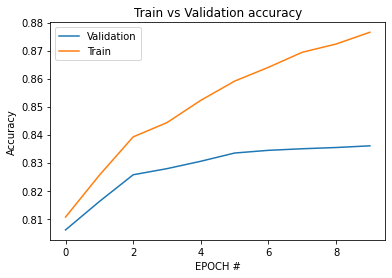

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(val_acc)), val_acc, label = "Validation")
plt.plot(np.arange(len(train_acc)), train_acc, label = "Train")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('EPOCH #')
plt.title('Train vs Validation accuracy')
plt.savefig('train_vs_validation_acc.png')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'EPOCH #')

Text(0.5, 1.0, 'Train vs Validation Loss')

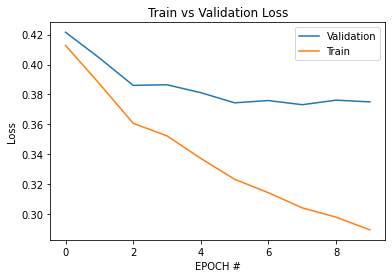

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(val_loss)), val_loss, label = "Validation")
plt.plot(np.arange(len(train_loss)), train_loss, label = "Train")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('EPOCH #')
plt.title('Train vs Validation Loss')
plt.savefig('train_vs_validation_loss.png')

In [ ]:
torch.cuda.empty_cache()